#**Exploratory Analysis of UK Pet Cat Movement Data**
A1 Team6:
*   Yuanhao Li
*   Junqi Fang
*   Zexuan Wang
*   Xinying Wang





## 1.Motivation & Executive Summary

Pet cats are one of the most common companion animals, yet their movement behavior varies widely across individuals and environments. Understanding how they move across space is relevant for wildlife conservation urban planning and household level interventions. This notebook conducts preliminary exploratory data analysis on the UK Pet Cats dataset in order to identify meaningful questions for unsupervised machine learning analysis. The dataset consists primarily of unlabeled event level movement records collected from GPS tracked domestic cats along with a separate reference table describing cat level characteristics.

We first examine data structure and observation imbalance to understand what units of analysis are meaningful. We then examine observation density temporal coverage spatial distribution movement range proxies and basic links between movement patterns and reported cat attributes. Our exploratory findings suggest substantial differentiation across cats in terms of sampling intensity spatial extent and apparent movement behavior. We also observe strong spatial clustering and the presence of extreme values that persist even after basic filtering.



## 2.Data Importing and Overview

This section checks the basic structure of the Pet Cats dataset and evaluates feasibility for unsupervised analysis. The dataset consist of time stamped event records for individual cats, along with a reference table describing attributes such as age, sex and household constraints.

### 2.1 Load data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

events_url = "https://raw.githubusercontent.com/paddington-L831/BA820-Unsupervised-and-Unstructured-Machine-Learning/main/cats_uk.csv"
ref_url = "https://raw.githubusercontent.com/paddington-L831/BA820-Unsupervised-and-Unstructured-Machine-Learning/main/cats_uk_reference.csv"

events = pd.read_csv(events_url)
ref = pd.read_csv(ref_url)

print("events:", events.shape)
print("ref:", ref.shape)

events.head()

events: (18215, 11)
ref: (101, 16)


,tag_id,event_id,visible,timestamp,location_long,location_lat,ground_speed,height_above_ellipsoid,algorithm_marked_outlier,manually_marked_outlier,study_name
0,Ares,3395610551,True,2017-06-24T01:03:57Z,-5.113851,50.170315,684,154.67,False,False,Pet Cats United Kingdom
1,Ares,3395610552,True,2017-06-24T01:11:20Z,-5.113851,50.170315,936,154.67,False,False,Pet Cats United Kingdom
2,Ares,3395610553,True,2017-06-24T02:58:16Z,-5.113730,50.169876,2340,81.35,False,False,Pet Cats United Kingdom
3,Ares,3395610554,True,2017-06-24T03:01:26Z,-5.113774,50.169827,0,67.82,False,False,Pet Cats United Kingdom
4,Ares,3395610555,True,2017-06-24T03:51:58Z,-5.114247,50.170139,4896,118.03,False,False,Pet Cats United Kingdom


In [ ]:
ref.head(3)

,tag_id,animal_id,animal_taxon,deploy_on_date,deploy_off_date,hunt,prey_p_month,animal_reproductive_condition,animal_sex,hrs_indoors,n_cats,food_dry,food_wet,food_other,study_site,age_years
0,Tommy-Tag,Tommy,Felis catus,2017-06-03T01:02:09Z,2017-06-10T02:10:52Z,True,12.5,Neutered,m,12.5,2,True,True,False,UK,11.0
1,Athena,Athena,Felis catus,2017-06-24T01:02:13Z,2017-06-30T23:59:32Z,True,3.0,Spayed,f,7.5,2,True,True,False,UK,3.0
2,Ares,Ares,Felis catus,2017-06-24T01:03:57Z,2017-06-30T23:58:01Z,NaN,0.0,Neutered,m,7.5,2,True,True,False,UK,3.0


### 2.2 Columns and missing values overview

In [ ]:
print("EVENTS columns:", events.columns.tolist())
print("REF columns:", ref.columns.tolist())

# Missing rate
events_missing = events.isna().mean().sort_values(ascending=False)
ref_missing = ref.isna().mean().sort_values(ascending=False)

print("\nTop missing in EVENTS:")
print(events_missing.head(10))

print("\nTop missing in REF:")
print(ref_missing.head(10))

EVENTS columns: ['tag_id', 'event_id', 'visible', 'timestamp', 'location_long', 'location_lat', 'ground_speed', 'height_above_ellipsoid', 'algorithm_marked_outlier', 'manually_marked_outlier', 'study_name']
REF columns: ['tag_id', 'animal_id', 'animal_taxon', 'deploy_on_date', 'deploy_off_date', 'hunt', 'prey_p_month', 'animal_reproductive_condition', 'animal_sex', 'hrs_indoors', 'n_cats', 'food_dry', 'food_wet', 'food_other', 'study_site', 'age_years']

Top missing in EVENTS:
tag_id                      0.0
event_id                    0.0
visible                     0.0
timestamp                   0.0
location_long               0.0
location_lat                0.0
ground_speed                0.0
height_above_ellipsoid      0.0
algorithm_marked_outlier    0.0
manually_marked_outlier     0.0
dtype: float64

Top missing in REF:
food_other                       0.099010
hunt                             0.089109
animal_reproductive_condition    0.029703
age_years                        0.0

### 2.3 Timestamp parsing feasibility

In [ ]:
events["dt"] = pd.to_datetime(events["timestamp"], errors="coerce")

# Check how many timestamps failed to parse
print("Bad timestamps:", events["dt"].isna().sum())

# Inspect the overall time range
print("Time range:", events["dt"].min(), "to", events["dt"].max())

Bad timestamps: 0
Time range: 2017-06-03 01:02:09+00:00 to 2017-11-30 00:52:55+00:00


### 2.4 Merge tables

We merge the event-level GPS data with cat-level reference attributes using tag_id.

In [ ]:
df = events.merge(ref, on="tag_id", how="left")

print("Merged df shape:", df.shape)

# Estimate how often reference information is missing after merging
ref_cols = [c for c in ref.columns if c != "tag_id"]
missing_ref_rate = df[ref_cols].isna().all(axis=1).mean()
print("Share of events missing ALL ref fields:", missing_ref_rate)

Merged df shape: (18215, 27)
Share of events missing ALL ref fields: 0.0


## 3.Sampling Density and Observation Imbalance

Before analyzing movement patterns, we want to understand how observation density varies across cats in tracking data. This helps check if the dataset is imbalanced across cats, since cats with dense tracking histories may heavily influence aggregate statistics results while sparsely tracked cats may appear anomalous even if their behavior is typical.


### 3.1 Number of observations per cat

This code summarizes how many GPS observations are available for each cat.  The goal is to assess whether observation density is evenly distributed or dominated by a small number of individuals.  

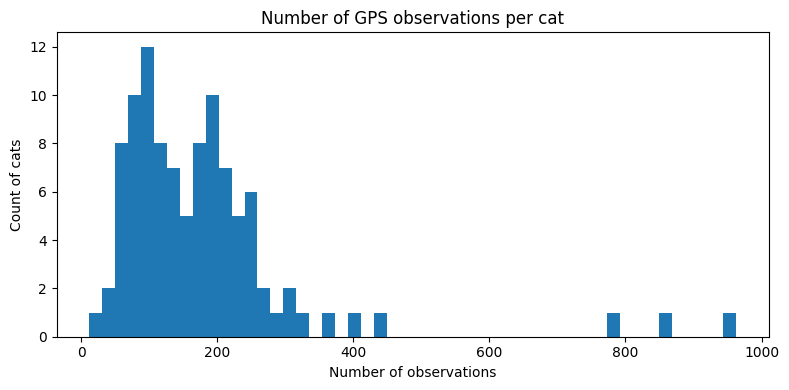

In [ ]:
obs_per_cat = events.groupby("tag_id").size().sort_values(ascending=False)
obs_per_cat.describe(percentiles=[0.5, 0.9, 0.95, 0.99])

plt.figure(figsize=(8, 4))
plt.hist(obs_per_cat, bins=50)
plt.title("Number of GPS observations per cat")
plt.xlabel("Number of observations")
plt.ylabel("Count of cats")
plt.tight_layout()
plt.show()

We find the number of GPS observations varies widely across cats with a small number of cats contributing a very large share of the data.

### 3.2 Tracking duration per cat

This code computes the temporal coverage for each cat based on the first and last recorded observation.  

In [ ]:
events_sorted = events.sort_values(["tag_id", "dt"])
duration = events_sorted.groupby("tag_id")["dt"].agg(["min", "max"])
duration["days_tracked"] = (duration["max"] - duration["min"]).dt.total_seconds() / 86400
duration["days_tracked"].describe(percentiles=[0.5, 0.9, 0.95, 0.99])

,days_tracked
count,101.000000
mean,7.021158
std,3.337898
min,0.506968
50%,6.975764
90%,7.737222
95%,8.233877
99%,27.409850
max,28.959236


## 4.Data Quality and Outlier Flags

We check how many records were flagged as outliers by an algorithm and how many were manually flagged as outliers. Outliers may represent sensor errors or implausible measurements. They may also capture genuinely rare but meaningful behaviors.

In [ ]:
flag_cols = [c for c in ["algorithm_marked_outlier", "manually_marked_outlier"] if c in events.columns]
if flag_cols:
  events[flag_cols].mean()

This code summarizes the distribution of movement speed values.  We can see that there exists a large number of extreme values.

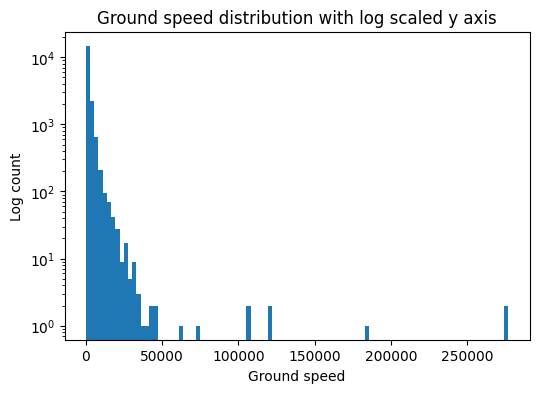

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(events["ground_speed"].dropna(), bins=100)
plt.yscale("log")
plt.title("Ground speed distribution with log scaled y axis")
plt.xlabel("Ground speed")
plt.ylabel("Log count")
plt.show()

We find that The speed distribution is heavily left skewed with some extreme values indicating the presence of either measurement noise or rare but unusual movement events.

## 5.Spatial and Movement Patterns

### 5.1 Coordinate ranges and basic scatter map

The chart below inspects the range of latitude and longitude values in the dataset.

In [ ]:
coord_cols = [c for c in ["location_long", "location_lat"] if c in events.columns]
events[coord_cols].describe()

,location_long,location_lat
count,18215.000000,18215.000000
mean,-4.988242,50.296238
std,0.301499,0.158353
min,-5.758854,50.103519
25%,-5.157051,50.153644
50%,-5.073365,50.236397
75%,-4.795648,50.428098
max,-4.208614,50.882217


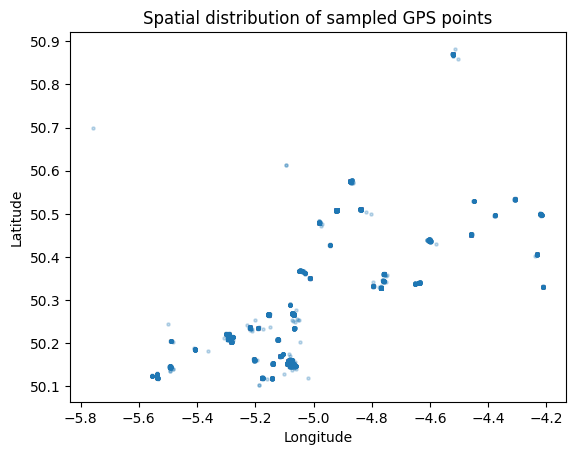

In [ ]:
sample = events.dropna(subset=coord_cols).sample(n=min(8000, len(events)), random_state=0)
plt.scatter(sample["location_long"], sample["location_lat"], alpha=0.25, s=5)
plt.title("Spatial distribution of sampled GPS points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

GPS observations are spatially clustered rather than evenly distributed indicating that movement is concentrated in specific geographic regions.


### 5.2 Simple per cat range proxy

We construct a simple proxy for each cat's movement range based on coordinate spans.  

In [ ]:
# Per cat movement range proxy
range_proxy = events.groupby("tag_id").agg(
  lon_min=("location_long", "min"),
  lon_max=("location_long", "max"),
  lat_min=("location_lat", "min"),
  lat_max=("location_lat", "max")
)
range_proxy["bbox_area_proxy"] = (range_proxy["lon_max"] - range_proxy["lon_min"]) * ( range_proxy["lat_max"] - range_proxy["lat_min"])
range_proxy["bbox_area_proxy"].describe(percentiles=[0.5, 0.9, 0.95, 0.99])

,bbox_area_proxy
count,1.010000e+02
mean,4.746304e-03
std,3.212340e-02
min,8.643000e-07
50%,2.761891e-05
90%,1.086556e-03
95%,2.769142e-03
99%,1.164898e-01
max,3.011279e-01


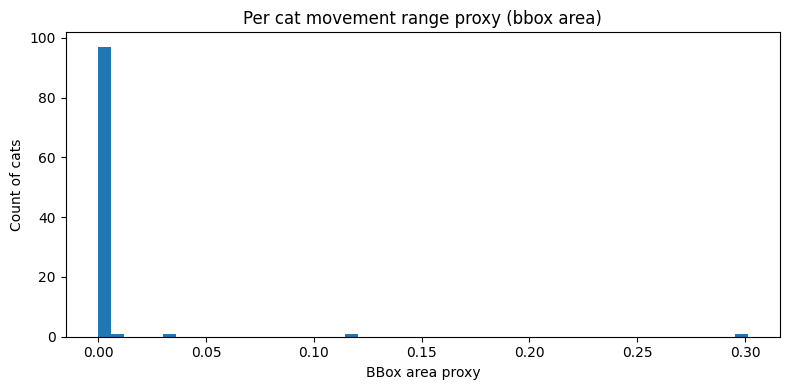

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(
    range_proxy["bbox_area_proxy"].replace([np.inf, -np.inf], np.nan).dropna(),
    bins=50
)
plt.title("Per cat movement range proxy (bbox area)")
plt.xlabel("BBox area proxy")
plt.ylabel("Count of cats")
plt.tight_layout()
plt.show()

Estimated movement ranges vary substantially across cats with most showing limited spatial extent and a small number exhibiting much larger ranges.


### 5.3 Interactive map using Folium

We want to use this map to visualize the geographic distribution of GPS observations to provide an intuitive sense of spatial coverage and clustering.

In [ ]:
import folium

# Select valid coordinate records
coords = events.dropna(subset=["location_lat", "location_long"]).copy()

frac = 0.30
cap = 50_000

if len(coords) > cap:
    map_sample = coords.sample(n=cap, random_state=0)
else:
    map_sample = coords.sample(frac=frac, random_state=0)

# Compute map center
center_lat = map_sample["location_lat"].mean()
center_lon = map_sample["location_long"].mean()

# Initialize map
m = folium.Map(location=[center_lat, center_lon], zoom_start=6, tiles="OpenStreetMap")

# Add points to map
for _, r in map_sample.iterrows():
    folium.CircleMarker(location=[r["location_lat"], r["location_long"]], radius=2, fill=True, fill_opacity=0.4, opacity=0).add_to(m)
m

### 6. Synthesis and Final Domain Questions

Question 1: Do UK pet cats fall into different “roaming styles” based on how far they travel (bbox area proxy), how much time they stay indoors (hrs_indoors), and how many prey they bring home (prey_p_month)?

EDA motivation: Our EDA shows that most cats stay in a small area, but a few cats move across a much bigger range based on bbox_area_proxy. We also saw that hrs_indoors and prey_p_month fall into clear levels instead of spreading smoothly.

Why it matters: If cats fall into clear roaming groups, owners can give different advice to different types of cats. This helps focus attention on cats that may create higher wildlife risk.

What would be surprising: It would be surprising if cats that roam the most do not have higher prey numbers. That would mean roaming far is not a good sign of hunting risk.



Question 2: Which cats have the most similar movement patterns, for example where they go and how their speed looks? Do those “similar cats” also have similar prey levels?

EDA motivation: We found big differences across cats in how many GPS points they have and how long they were tracked. We also have detailed GPS data like location and speed, so we can compare cats by their movement patterns.

Why it matters: If cats with similar movement patterns also have similar prey levels, we can group cats and give simple behavior-based guidance. This can help owners understand risk even when we do not have perfect information for every cat.

What would be surprising: It would be surprising if cats that move in very similar ways have very different prey levels. That would suggest hunting depends more on local environment or home conditions than movement behavior.

Question 3: Are the highest speed records real cat behavior or tracking mistakes? How does removing these extreme records change the patterns we see in cat movement?

EDA motivation: The ground_speed values have a long tail, meaning some records show extremely high speeds. The dataset also includes outlier flags, which suggests some events may be mistakes or rare unusual cases.

Why it matters: If the extreme speeds are errors, we should remove them so they do not ruin our results. If they are real, they could signal unusual behavior or safety risks for certain cats.

What would be surprising: It would be surprising if extreme speeds happen evenly across many cats. That would strongly suggest the issue is tracking noise, not special behavior from a few cats.

Question 4: How do differences in tracking time and GPS points per cat affect our results? What is the fairest way to compare cats that were tracked for a short time versus a long time?

EDA motivation: Our EDA shows cats were tracked for very different lengths of time, from about half a day to almost 29 days. Some cats also have far more GPS records than others, which makes the dataset uneven.

Why it matters: Cats with more tracking data may look more active just because we observed them more often. Fair comparison rules help us avoid wrong conclusions and make better recommendations.

What would be surprising: It would be surprising if cats tracked for only a short time still show clear and stable movement patterns. That would mean even short tracking can be enough to understand a cat’s behavior type.